In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Feb 14 07:13:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('./MyDrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./MyDrive


In [0]:
TRAIN_DIR = "MyDrive/My Drive/ai/workspace/data/cats_and_dogs_small/train/"
TEST_DIR = "MyDrive/My Drive/ai/workspace/data/cats_and_dogs_small/test/"

In [0]:
IM_WIDTH = 224
IM_HEIGHT = 224
train_batch_size = 16
test_batch_size = 10

In [0]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

In [0]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size = train_batch_size,
    class_mode="binary",
    shuffle=True
)

Found 2000 images belonging to 2 classes.


## 테스트 데이터 읽어오기

In [0]:
test_datagen = ImageDataGenerator(
    rescale= 1./255,
)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size = test_batch_size,
    class_mode="binary",
    shuffle=False
)

Found 1000 images belonging to 2 classes.


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam

## 모델이 있으면 로드 없으면 새롭게 만들고 학습

In [0]:
import os
isModelPresented = True
model_path = "MyDrive/My Drive/cats_and_dogs_small_cnn.h5"
if os.path.isfile(model_path) is False:
    isModelPresented = False

In [0]:
from keras.models import load_model
if isModelPresented is False:    # 모델이 없다면
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(IM_WIDTH, IM_HEIGHT, 3), activation="relu", padding="SAME"))
    model.add(MaxPooling2D(pool_size=2, padding="SAME"))
    model.add(Conv2D(64, kernel_size=(3, 3), activation="relu", padding="SAME"))
    model.add(MaxPooling2D(pool_size=2, padding="SAME"))
    model.add(Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation="relu", padding="SAME"))
    model.add(Conv2D(256, kernel_size=(3, 3), strides=(2, 2), activation="relu", padding="SAME"))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(rate = 0.5))
    model.add(Dense(1, activation="sigmoid"))
else:
    model = load_model(model_path)

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 256)       295168    
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)            

## 처음 lr = 0.0005 로 60번 돌림
## 이후 lr = 0.0001로 바꿔서 90번 돌림

In [0]:
if isModelPresented is False:
    model.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.00005), metrics=['acc'])
    model.fit(train_generator, epochs=30)

## Test 데이터를 활용한 모델 평가

In [0]:
sum_score = 0
test_len = int(train_generator.n / test_batch_size)
for x in range(test_len):
    test_x, test_y = test_generator.next()
    predict = model.predict(test_x)
    pred = np.where(predict>0.5, 1, 0)
    pred = pred.reshape(-1)
    pred01 = (pred == test_y)
    sum_score += np.sum(pred01)
    # print(f"{x + 1} / {test_len} = { (x+1) / test_len}   acc = {sum_score / (test_batch_size * (x+1))}\r")
    sys.stdout.flush()
    print("Progress {0} / {1} = {2}    acc = {3} ".format(x+1, test_len, ((x+1)/test_len), sum_score / (test_batch_size * (x+1)),  end="\r"))
    # time.sleep(1)
    
    # print("Progress {:2.1%}".format(x / 10), end="\r")
acc = sum_score / train_generator.n
acc

Progress 1 / 200 = 0.005    acc = 0.9 
Progress 2 / 200 = 0.01    acc = 0.85 
Progress 3 / 200 = 0.015    acc = 0.8333333333333334 
Progress 4 / 200 = 0.02    acc = 0.825 
Progress 5 / 200 = 0.025    acc = 0.82 
Progress 6 / 200 = 0.03    acc = 0.85 
Progress 7 / 200 = 0.035    acc = 0.8571428571428571 
Progress 8 / 200 = 0.04    acc = 0.8375 
Progress 9 / 200 = 0.045    acc = 0.8333333333333334 
Progress 10 / 200 = 0.05    acc = 0.84 
Progress 11 / 200 = 0.055    acc = 0.8454545454545455 
Progress 12 / 200 = 0.06    acc = 0.825 
Progress 13 / 200 = 0.065    acc = 0.8307692307692308 
Progress 14 / 200 = 0.07    acc = 0.8 
Progress 15 / 200 = 0.075    acc = 0.7933333333333333 
Progress 16 / 200 = 0.08    acc = 0.775 
Progress 17 / 200 = 0.085    acc = 0.7705882352941177 
Progress 18 / 200 = 0.09    acc = 0.7666666666666667 
Progress 19 / 200 = 0.095    acc = 0.7631578947368421 
Progress 20 / 200 = 0.1    acc = 0.77 
Progress 21 / 200 = 0.105    acc = 0.7714285714285715 
Progress 22 / 20

0.785


## 모델 저장

In [0]:
# model.save("MyDrive/My Drive/cats_and_dogs_small_cnn.h5")

In [0]:
img_path = "MyDrive/My Drive/ai/workspace/data/cats_and_dogs_small/test/cats/cat.1999.jpg"

In [0]:
from keras.preprocessing import image

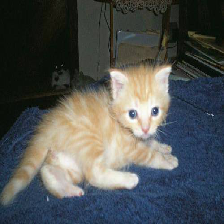

In [0]:
img = image.load_img(img_path, target_size = (IM_WIDTH, IM_HEIGHT))
img

In [0]:
img_tensor = image.img_to_array(img)
img_tensor.shape

(224, 224, 3)

In [0]:
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor.shape

(1, 224, 224, 3)

In [0]:
img_tensor = img_tensor/255.

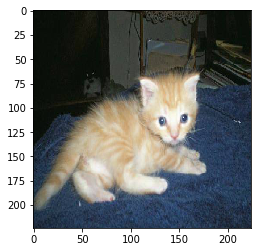

In [0]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In [0]:
model.layers[:6]

In [0]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:6]]
layer_outputs

[<tf.Tensor 'conv2d_1_1/Relu:0' shape=(?, 224, 224, 32) dtype=float32>,
 <tf.Tensor 'max_pooling2d_1_1/MaxPool:0' shape=(?, 112, 112, 32) dtype=float32>,
 <tf.Tensor 'conv2d_2_1/Relu:0' shape=(?, 112, 112, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_2_1/MaxPool:0' shape=(?, 56, 56, 64) dtype=float32>,
 <tf.Tensor 'conv2d_3_1/Relu:0' shape=(?, 28, 28, 128) dtype=float32>,
 <tf.Tensor 'conv2d_4_1/Relu:0' shape=(?, 14, 14, 256) dtype=float32>]

In [0]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activation_model

In [0]:
activations = activation_model.predict(img_tensor)
activations

[array([[[[0.        , 0.        , 0.        , ..., 0.        ,
           0.00843792, 0.0171508 ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.0100143 , 0.00768973],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.0100143 , 0.00768973],
          ...,
          [0.00088835, 0.        , 0.        , ..., 0.        ,
           0.00816283, 0.0032303 ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.00512151, 0.00863733],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.02427539, 0.        ]],
 
         [[0.        , 0.        , 0.        , ..., 0.        ,
           0.0072014 , 0.03089308],
          [0.        , 0.        , 0.        , ..., 0.0002419 ,
           0.02042303, 0.0182324 ],
          [0.        , 0.        , 0.        , ..., 0.0002419 ,
           0.02042303, 0.0182324 ],
          ...,
          [0.        , 0.        , 0.        , ..., 0.00296464,
   

In [0]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 224, 224, 32)


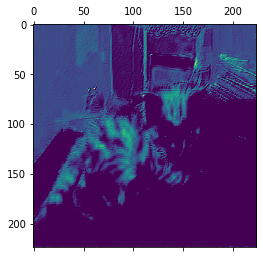

In [0]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap="viridis")
plt.show()

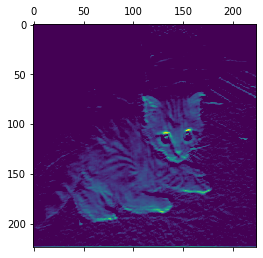

In [0]:
plt.matshow(first_layer_activation[0, :, :, 16], cmap="viridis")
plt.show()

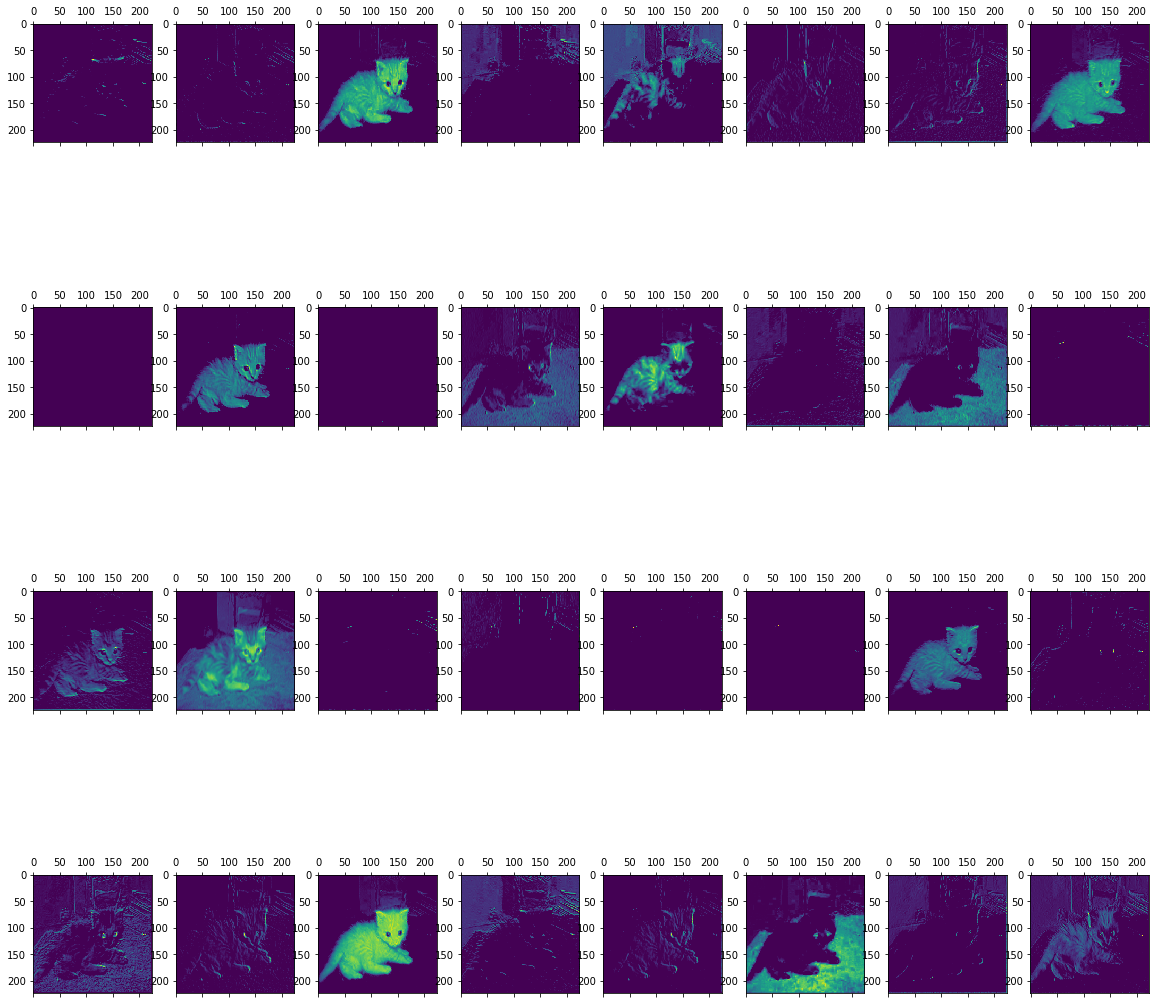

In [0]:
layer_out = activations[0]
fig = plt.figure(figsize=(20, 20))
for i in range(32):
    subplot = fig.add_subplot(4, 8, i+1)
    subplot.matshow(layer_out[0, :, :, i], cmap="viridis")

plt.show()